# Classic Regression


## Load Data

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.svm import SVR 

from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

sns.set_style('darkgrid')

data_file = './data/model_ready.parquet'
df = pd.read_parquet(data_file, "pyarrow")

# sort index
df = df.sort_index()
# the frequency of the datatime index is not set. based on inspection, it is sampled hourly. here i will set the frequency to 1 hour in case in the future i may need to resample the data.
df = df.asfreq('H')

# separte names for inspection
columns = df.columns
load_names = []
wind_names = []
dewpoint_names = []
target_names = []
for col in columns:
    if 'mtlf' in col:
        load_names.append(col)
    if 'ws' in col:
        wind_names.append(col)
    if 'td' in col:
        dewpoint_names.append(col)
    if 'da_energy' in col:
        target_names.append(col)


## Features

As analyzed before, we will add the following features to dataset:
1. detrend target as previously we have shown the target is non stationary
1. time features: sine and cosine pairs of day, bimonth and year
2. add lags of (1,2,5,9) of the targets to the dataset



In [17]:
target = target_names[0]

# add time features
date_time = df.index
timestamp_s = date_time.map(pd.Timestamp.timestamp)

# the data has obvious daily pattern, bimonth pattern and annual pattern
day = 24*60*60
bimonth = (365.2425/6)*day
year = (365.2425)*day

# use cos/sin as 0 should be close to 23
df['day_sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['day_cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['bimonth_sin'] = np.sin(timestamp_s * (2 * np.pi / bimonth))
df['bimonth_cos'] = np.cos(timestamp_s * (2 * np.pi / bimonth))
df['year_sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['year_cos'] = np.cos(timestamp_s * (2 * np.pi / year))


In [18]:
# we need use current step to predict next step, so we need to shift the target column by 1 step
# or we can do multistep predictions
n_futures = 1 
futures = [i for i in range(1, n_futures+1)]
lags = [1, 2, 5, 9]

def make_lags_futures(df, target, lags, futures):
    for lag in lags:
        df[f'{target}_lag_{lag-1}'] = df[target].shift(lag-1)
    for future in futures:
        df[f'{target}_future_{future}'] = df[target].shift(-future)
    df = df.drop(columns = [target])
    return df.dropna()

# drop other targets 
df['target'] = df[target]
df = df.drop(columns=target_names)
df = make_lags_futures(df, 'target', lags, futures)

target = 'target_future_1'
X = df.drop(columns=target)
y = df[target]



In [19]:
y.max(), y.min()

(830.95, -22.12)

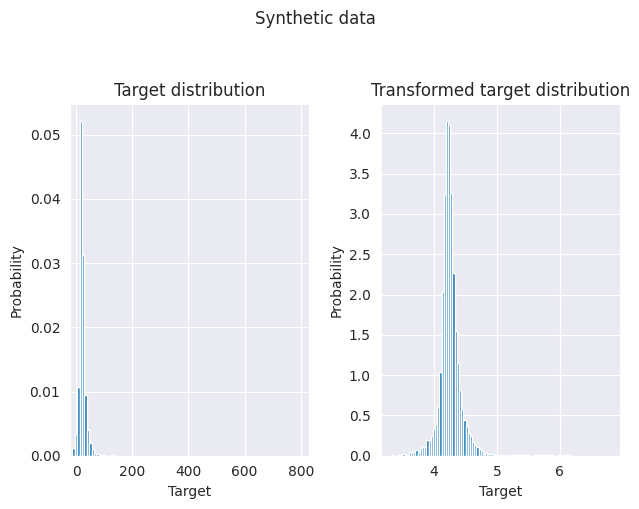

In [20]:
f, (ax0, ax1) = plt.subplots(1, 2)

ax0.hist(y, bins=100, density=True)
ax0.set_xlim([y.min(), y.max()])
ax0.set_ylabel("Probability")
ax0.set_xlabel("Target")
ax0.set_title("Target distribution")

y_trans = np.log(y+50)
ax1.hist(y_trans, bins=100, density=True)
ax1.set_ylabel("Probability")
ax1.set_xlabel("Target")
ax1.set_title("Transformed target distribution")

f.suptitle("Synthetic data", y=1.05)
plt.tight_layout()

In [21]:
# split train and test
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

#y = np.log(y+50)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=False, random_state=42)
#X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_ratio/(train_ratio+val_ratio), shuffle=False, random_state=42)



In [22]:
from sklearn.model_selection import TimeSeriesSplit

ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=48
)

Xy_splits = list(ts_cv.split(X_train_val, y_train_val))

# check the first split
train_0, val_0 = Xy_splits[0]
X_train_val.iloc[train_0]

,central_mtlf_fc,north_mtlf_fc,south_mtlf_fc,system_mtlf_fc,ia_ksux_ws_mph_fc,il_kmdw_ws_mph_fc,il_kord_ws_mph_fc,mi_kanj_ws_mph_fc,mi_karb_ws_mph_fc,mi_kazo_ws_mph_fc,...,day_sin,day_cos,bimonth_sin,bimonth_cos,year_sin,year_cos,target_lag_0,target_lag_1,target_lag_4,target_lag_8
interval_ending_dt_utc,,,,,,,,,,,,,,,,,,,,,
2019-09-01 08:00:00,30300.0,12370.0,18380.0,61050.0,3.263299,3.129191,2.682164,0.894055,0.894055,1.206974,...,8.660254e-01,-0.500000,-0.004559,0.999990,-0.865645,-0.500658,14.27,14.90,18.98,21.95
2019-09-01 09:00:00,29980.0,12240.0,17960.0,60170.0,3.442110,3.129191,2.682164,0.894055,0.894055,1.028163,...,7.071068e-01,-0.707107,-0.000258,1.000000,-0.866004,-0.500037,13.61,14.27,18.06,20.77
2019-09-01 10:00:00,30140.0,12220.0,17700.0,60070.0,3.576218,3.129191,2.682164,0.894055,0.894055,0.894055,...,5.000000e-01,-0.866025,0.004043,0.999992,-0.866362,-0.499416,13.61,13.61,15.66,20.82
2019-09-01 11:00:00,30660.0,12370.0,17700.0,60740.0,3.442110,3.129191,2.682164,0.894055,1.028163,1.028163,...,2.588190e-01,-0.965926,0.008343,0.999965,-0.866720,-0.498795,14.19,13.61,14.90,18.43
2019-09-01 12:00:00,31160.0,12610.0,17730.0,61500.0,3.263299,3.129191,2.682164,0.894055,1.206974,1.206974,...,1.334979e-11,-1.000000,0.012644,0.999920,-0.867077,-0.498174,14.44,14.19,14.27,18.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-11 10:00:00,38440.0,17200.0,18880.0,74520.0,3.129191,4.470273,4.023245,5.364327,4.470273,5.364327,...,5.000000e-01,-0.866025,-0.843705,-0.536808,-0.348754,0.937214,16.41,15.89,14.71,28.92
2019-12-11 11:00:00,40030.0,17530.0,19470.0,77030.0,3.442110,4.470273,4.470273,5.498435,4.917300,5.498435,...,2.588190e-01,-0.965926,-0.846006,-0.533174,-0.348082,0.937464,15.69,16.41,14.66,26.00
2019-12-11 12:00:00,42980.0,18470.0,20720.0,82180.0,3.710326,4.470273,4.917300,5.677246,5.364327,5.677246,...,1.202935e-12,-1.000000,-0.848291,-0.529531,-0.347410,0.937713,17.11,15.69,14.85,23.36


In [23]:
# Adding these features wont help too much on linear regression
"""
# add deterministic features from statsmodels
fourier = CalendarFourier(freq="W", order=12)  # 10 sin/cos pairs for Weekly seasonality
dp_train_val = DeterministicProcess(
    index=y_train_val.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # daily seasonality (indicators)
    additional_terms=[fourier],         # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)
X_dp_train = dp_train_val.in_sample()  # create features 
X_train_val = pd.concat([X_train_val, X_dp_train], axis=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_ratio/(train_ratio+val_ratio), shuffle=False, random_state=42)

X_dp_test = dp_train_val.out_of_sample(steps=len(y_test))
X_test = pd.concat([X_test, X_dp_test], axis=1)
"""

'\n# add deterministic features from statsmodels\nfourier = CalendarFourier(freq="W", order=12)  # 10 sin/cos pairs for Weekly seasonality\ndp_train_val = DeterministicProcess(\n    index=y_train_val.index,\n    constant=True,               # dummy feature for bias (y-intercept)\n    order=1,                     # trend (order 1 means linear)\n    seasonal=True,               # daily seasonality (indicators)\n    additional_terms=[fourier],         # annual seasonality (fourier)\n    drop=True,                   # drop terms to avoid collinearity\n)\nX_dp_train = dp_train_val.in_sample()  # create features \nX_train_val = pd.concat([X_train_val, X_dp_train], axis=1)\nX_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_ratio/(train_ratio+val_ratio), shuffle=False, random_state=42)\n\nX_dp_test = dp_train_val.out_of_sample(steps=len(y_test))\nX_test = pd.concat([X_test, X_dp_test], axis=1)\n'

In [24]:
"""
# directly load from saved processed data
X_train_val = pd.read_csv('./data/X_train.csv', index_col=0)
X_test = pd.read_csv('./data/X_test.csv', index_col=0)
y_train_val = pd.read_csv('./data/y_train.csv', index_col=0)
y_test = pd.read_csv('./data/y_test.csv', index_col=0)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_ratio/(train_ratio+val_ratio), shuffle=False, random_state=42)
"""

"\n# directly load from saved processed data\nX_train_val = pd.read_csv('./data/X_train.csv', index_col=0)\nX_test = pd.read_csv('./data/X_test.csv', index_col=0)\ny_train_val = pd.read_csv('./data/y_train.csv', index_col=0)\ny_test = pd.read_csv('./data/y_test.csv', index_col=0)\n\nX_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_ratio/(train_ratio+val_ratio), shuffle=False, random_state=42)\n"

In [25]:
X_train_val.columns

Index(['central_mtlf_fc', 'north_mtlf_fc', 'south_mtlf_fc', 'system_mtlf_fc',
       'ia_ksux_ws_mph_fc', 'il_kmdw_ws_mph_fc', 'il_kord_ws_mph_fc',
       'mi_kanj_ws_mph_fc', 'mi_karb_ws_mph_fc', 'mi_kazo_ws_mph_fc',
       'mi_klan_ws_mph_fc', 'mn_kinl_ws_mph_fc', 'mn_krst_ws_mph_fc',
       'mo_kstl_ws_mph_fc', 'oh_kakr_ws_mph_fc', 'ok_kclk_ws_mph_fc',
       'ok_kokc_ws_mph_fc', 'ok_ktul_ws_mph_fc', 'ok_kwdg_ws_mph_fc',
       'sc_kchs_ws_mph_fc', 'ar_kjbr_td_f_fc', 'ia_kdsm_td_f_fc',
       'ia_ksux_td_f_fc', 'in_kfwa_td_f_fc', 'in_kind_td_f_fc',
       'in_klaf_td_f_fc', 'in_ksbn_td_f_fc', 'ky_ksdf_td_f_fc',
       'la_kbtr_td_f_fc', 'la_klch_td_f_fc', 'la_kshv_td_f_fc',
       'mi_klan_td_f_fc', 'mn_kinl_td_f_fc', 'mn_kpqn_td_f_fc',
       'mo_ksgf_td_f_fc', 'mo_kstl_td_f_fc', 'oh_kluk_td_f_fc',
       'ok_klaw_td_f_fc', 'day_sin', 'day_cos', 'bimonth_sin', 'bimonth_cos',
       'year_sin', 'year_cos', 'target_lag_0', 'target_lag_1', 'target_lag_4',
       'target_lag_8'],
     

Text(0.5, 1.0, 'Test distribution')

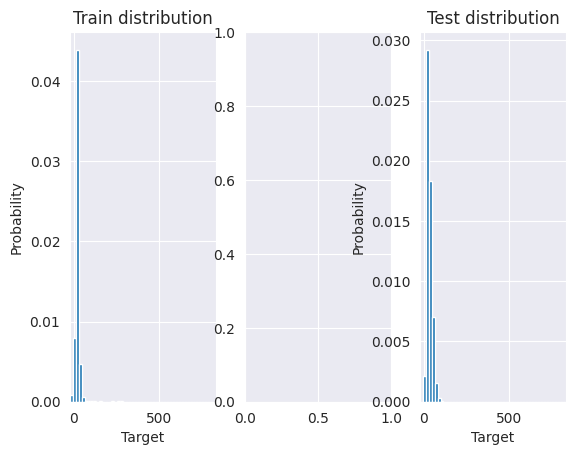

In [26]:
f, (ax0, ax1, ax2) = plt.subplots(1, 3)

ax0.hist(y_train_val, bins=50, range=[y.min(), y.max()], density=True)
ax0.set_xlim([y.min(), y.max()])
ax0.set_ylabel("Probability")
ax0.set_xlabel("Target")
ax0.set_title("Train distribution")

#ax1.hist(y_val, bins=50, range=[y.min(), y.max()], density=True)
#ax1.set_xlim([y.min(), y.max()])
#ax1.set_ylabel("Probability")
#ax1.set_xlabel("Target")
#ax1.set_title("Val distribution")

ax2.hist(y_test, bins=50, range=[y.min(), y.max()], density=True)
ax2.set_xlim([y.min(), y.max()])
ax2.set_ylabel("Probability")
ax2.set_xlabel("Target")
ax2.set_title("Test distribution")

seems validation and testing distribution is not the similar. Maybe the data from 2021-02 where there are serious shortage of supply in MISO that lead to price spike. 

We probably need remove that data.

## Baseline Model
Use previous step's target as prediction

### One-step

In [27]:
y_test_base = y.shift(1)[-len(y_test):]

# baseline model metrics
mse_test_base = mean_squared_error(y_test, y_test_base)
mae_test_base = mean_absolute_error(y_test, y_test_base)
r2_score_base = r2_score(y_test, y_test_base)
print(f"baseline model metrics: mse: {mse_test_base}, mae: {mae_test_base}, r2: {r2_score_base}")

baseline model metrics: mse: 16.889430487804876, mae: 3.1287576219512196, r2: 0.9199722853065502


In [28]:
from sklearn.model_selection import cross_validate

def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )


## Linear Regression

In [29]:
std_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()
pca = PCA(n_components=0.95)
lasso = Lasso(fit_intercept=True, alpha=0.1, max_iter=100000)
lr = LinearRegression()

pipe = Pipeline(
    steps = [("reg", lasso)] 
)

evaluate(pipe, X_train_val, y_train_val, cv = ts_cv)

pipe.fit(X_train_val, y_train_val)
print(pipe.score(X_train_val, y_train_val), pipe.score(X_test, y_test))

def get_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, r2

# get metrics for train, val and test
y_train_pred = pd.Series(pipe.predict(X_train_val), index = y_train_val.index)
y_test_pred = pd.Series(pipe.predict(X_test), index = y_test.index) 

mse_train, mae_train, r2_score_train = get_metrics(y_train_val, y_train_pred)
print(f"train metrics: mse: {mse_train}, mae: {mae_train}, r2_score: {r2_score_train}")

mse_test, mae_test, r2_score_test = get_metrics(y_test, y_test_pred)
print(f"test metrics: mse: {mse_test}, mae: {mae_test}, r2_score: {r2_score_test}")


/home/yyf/miniconda3/envs/tts-tf/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.066e+02, tolerance: 1.706e+01
  model = cd_fast.enet_coordinate_descent(


Mean Absolute Error:     2.035 +/- 1.047
Root Mean Squared Error: 4.433 +/- 4.394
0.9640724578965895 0.9431864643316499
train metrics: mse: 26.169472914951513, mae: 1.8108102711443284, r2_score: 0.9640724578965895
test metrics: mse: 11.990199459182616, mae: 2.540834984971289, r2_score: 0.9431864643316499


## Ridge Regression


In [30]:
from sklearn.linear_model import RidgeCV
from sklearn.kernel_approximation import Nystroem
from sklearn.pipeline import make_pipeline

alphas = np.logspace(-6, 6, 100)
rg_pipe = make_pipeline(
    StandardScaler(),
    RidgeCV(alphas=alphas),
)
evaluate(rg_pipe, X_train_val, y_train_val, cv=ts_cv)

rg_pipe.fit(X_train_val, y_train_val)
print(rg_pipe.score(X_train_val, y_train_val), rg_pipe.score(X_test, y_test))

# get metrics for train, val and test
y_train_pred = pd.Series(rg_pipe.predict(X_train_val), index = y_train_val.index)
y_test_pred = pd.Series(rg_pipe.predict(X_test), index = y_test.index) 

mse_train, mae_train, r2_score_train = get_metrics(y_train_val, y_train_pred)
print(f"train metrics: mse: {mse_train}, mae: {mae_train}, r2_score: {r2_score_train}")

mse_test, mae_test, r2_score_test = get_metrics(y_test, y_test_pred)
print(f"test metrics: mse: {mse_test}, mae: {mae_test}, r2_score: {r2_score_test}")

Mean Absolute Error:     2.320 +/- 1.051
Root Mean Squared Error: 4.724 +/- 4.311
0.9641724163503318 0.9450850675573694
train metrics: mse: 26.096663591110154, mae: 1.8256760653240451, r2_score: 0.9641724163503318
test metrics: mse: 11.589509181726303, mae: 2.4801080689719237, r2_score: 0.9450850675573694


## SVR


In [31]:
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'svr__C': [0.1, 1, 10, 100], 'svr__gamma':[0.001, 0.01, 0.1], 'svr__kernel': ['rbf']}
 ]

svr = SVR(kernel='rbf', C=50)
svm_pipe = Pipeline(
    steps = [("scaler", std_scaler), ("pca", pca), ("svr", svr)]
)
svr_gs = GridSearchCV(svm_pipe, param_grid=param_grid, cv=ts_cv, scoring='neg_mean_absolute_error', n_jobs=-1)

svr_gs.fit(X_train_val, y_train_val - X_train_val['target_lag_0'])

# get metrics for train, val and test
y_train_pred = pd.Series(svr_gs.predict(X_train_val), index = y_train_val.index)
y_test_pred = pd.Series(svr_gs.predict(X_test), index = y_test.index) 

mse_train, mae_train, r2_score_train = get_metrics(y_train_val, y_train_pred + X_train_val['target_lag_0'])
print(f"train metrics: mse: {mse_train}, mae: {mae_train}, r2_score: {r2_score_train}")

mse_test, mae_test, r2_score_test = get_metrics(y_test, y_test_pred + X_test['target_lag_0'])
print(f"test metrics: mse: {mse_test}, mae: {mae_test}, r2_score: {r2_score_test}")

train metrics: mse: 35.3667433441646, mae: 1.6905606007884235, r2_score: 0.951445710630571
test metrics: mse: 9.163720624838415, mae: 2.054917955337035, r2_score: 0.9565792570551996


In [32]:
svr_gs.cv_results_
svr_gs.best_params_

{'svr__C': 1, 'svr__gamma': 0.01, 'svr__kernel': 'rbf'}

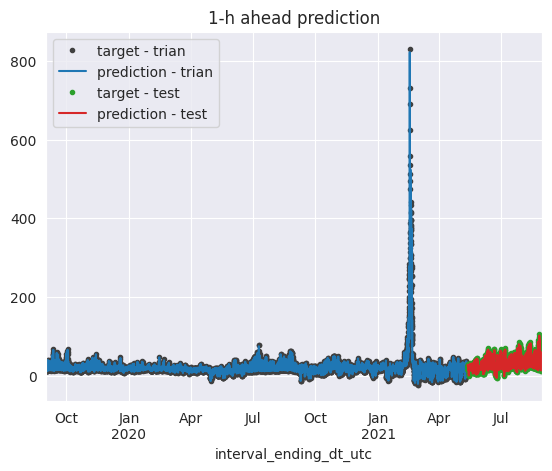

In [33]:
ax = y_train_val.plot(color='0.25', style='.', label = 'target - trian', title="1-h ahead prediction")
ax = (y_train_pred + X_train_val['target_lag_0']).plot(ax=ax, label="prediction - trian")
ax = y_test.plot(ax=ax, color='C2', style='.', label = 'target - test')
ax = (y_test_pred + X_test['target_lag_0']).plot(ax=ax, label="prediction - test", color='C3')
_ = ax.legend()

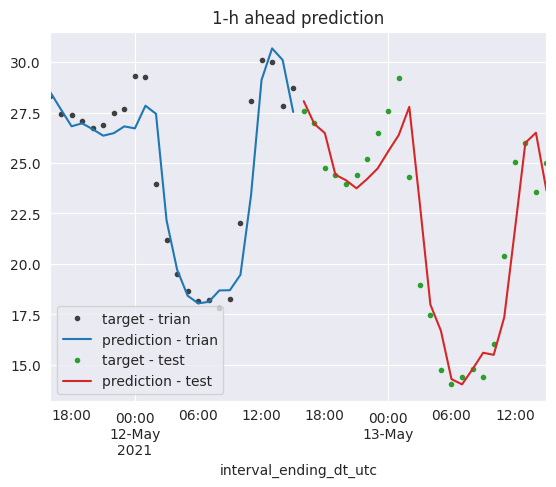

In [34]:
ax = y_train_val[-24:].plot(color='0.25', style='.', label = 'target - trian', title="1-h ahead prediction")
ax = (y_train_pred + X_train_val['target_lag_0'])[-24:].plot(ax=ax, label="prediction - trian")
ax = y_test[:24].plot(ax=ax, color='C2', style='.', label = 'target - test')
ax = (y_test_pred + X_test['target_lag_0'])[:24].plot(ax=ax, label="prediction - test", color='C3')
_ = ax.legend()

**The prediciton is always one-step delayed as the real data. This is because we are using the previous day's data to predict the current day's data.**



## XGB Tree

In [54]:
from sklearn.ensemble import RandomForestRegressor
import xgboost 

xgb = xgboost.XGBRegressor(
    objective ='reg:squarederror', 
    colsample_bytree = 0.3, 
    learning_rate = 0.1, 
    alpha = 10
    )

xgb_pipe = Pipeline([
    ('std', std_scaler), 
    ('pca', pca),
    ('xgb', xgb)]
    )

param_grid = {
    'xgb__max_depth': [4, 5, 6, 7],
    'xgb__n_estimators': [80, 90, 100],
}

gs = GridSearchCV(xgb_pipe, param_grid=param_grid, cv=ts_cv, scoring='neg_mean_absolute_error', n_jobs=-1)

gs.fit(X_train_val, y_train_val - X_train_val['target_lag_0'])

# get metrics for train, val and test
y_train_pred = pd.Series(gs.predict(X_train_val), index = y_train_val.index)
y_test_pred = pd.Series(gs.predict(X_test), index = y_test.index) 

mse_train, mae_train, r2_score_train = get_metrics(y_train_val, y_train_pred + X_train_val['target_lag_0'])
print(f"train metrics: mse: {mse_train}, mae: {mae_train}, r2_score: {r2_score_train}")

mse_test, mae_test, r2_score_test = get_metrics(y_test, y_test_pred + X_test['target_lag_0'])
print(f"test metrics: mse: {mse_test}, mae: {mae_test}, r2_score: {r2_score_test}")

train metrics: mse: 6.8938613867400695, mae: 1.555919828606956, r2_score: 0.9905355565993967
test metrics: mse: 11.103521288907128, mae: 2.346895292279553, r2_score: 0.9473878391315257


In [55]:
gs.best_params_

{'xgb__max_depth': 5, 'xgb__n_estimators': 90}

## XGB Random Forest

In [64]:
xgb = xgboost.XGBRFRegressor(
    objective ='reg:squarederror', 
    colsample_bytree = 0.3, 
    learning_rate = 0.1, 
    max_depth = 5, 
    alpha = 10, 
    n_estimators = 100, 
    booster='gbtree')

xgb_pipe = Pipeline([
    ('std', std_scaler), 
    ('pca', pca),
    ('xgb', xgb)]
    )

param_grid = {
    'xgb__alpha': [0.1, 0.5, 1],
    'xgb__max_depth': [2, 3, 5, 6],
    'xgb__n_estimators': [80, 90, 100],
}

gs = GridSearchCV(xgb_pipe, param_grid=param_grid, cv=ts_cv, scoring='neg_mean_absolute_error', n_jobs=-1)

gs.fit(X_train_val, y_train_val - X_train_val['target_lag_0'])

# get metrics for train, val and test
y_train_pred = pd.Series(gs.predict(X_train_val), index = y_train_val.index)
y_test_pred = pd.Series(gs.predict(X_test), index = y_test.index) 

mse_train, mae_train, r2_score_train = get_metrics(y_train_val, y_train_pred + X_train_val['target_lag_0'])
print(f"train metrics: mse: {mse_train}, mae: {mae_train}, r2_score: {r2_score_train}")

mse_test, mae_test, r2_score_test = get_metrics(y_test, y_test_pred + X_test['target_lag_0'])
print(f"test metrics: mse: {mse_test}, mae: {mae_test}, r2_score: {r2_score_test}")

train metrics: mse: 35.45834449151045, mae: 2.2086118510675785, r2_score: 0.9513199532609563
test metrics: mse: 17.000963339753547, mae: 3.100784248194953, r2_score: 0.9194438057192047


In [65]:
gs.best_params_

{'xgb__alpha': 0.1, 'xgb__max_depth': 6, 'xgb__n_estimators': 90}

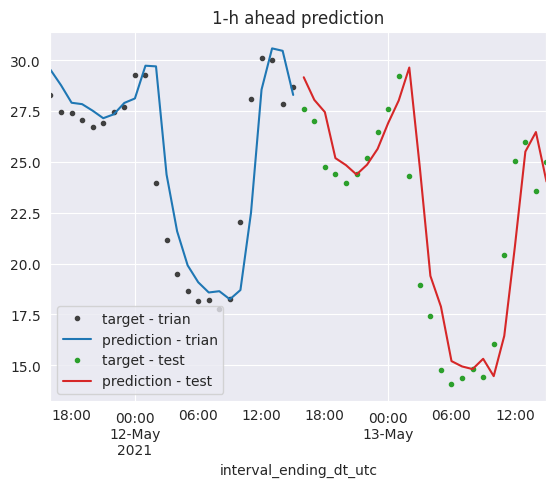

In [66]:
ax = y_train_val[-24:].plot(color='0.25', style='.', label = 'target - trian', title="1-h ahead prediction")
ax = (y_train_pred + X_train_val['target_lag_0'])[-24:].plot(ax=ax, label="prediction - trian")
ax = y_test[:24].plot(ax=ax, color='C2', style='.', label = 'target - test')
ax = (y_test_pred + X_test['target_lag_0'])[:24].plot(ax=ax, label="prediction - test", color='C3')
_ = ax.legend()